# Project: AI Learns to TikTok

---

In this notebook, we will use our model to generate dances from music. 

Use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset
- [Step 2](#step2): Visualise Spectrogram
- [Step 3](#step3): Load Trained Models
- [Step 4](#step4): Get Predicted Poses
- [Step 5](#step5): Generate dance video from outputs

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
%load_ext autoreload
%autoreload 2

import sys

from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

<a id='step2'></a>
## Step 2: Visualise Spectrogram


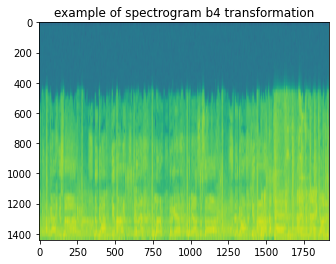

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_spectrogram, spectrogram = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_spectrogram))
plt.title('example of spectrogram b4 transformation')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


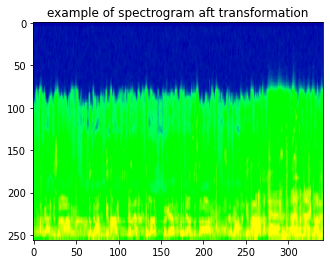

In [3]:
# Visualize sample image, after pre-processing.
plt.imshow(np.squeeze(spectrogram).permute(1,2,0))
plt.title('example of spectrogram aft transformation')
plt.show()

<a id='step3'></a>
## Step 3: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = "encoder-5.pkl"
decoder_file = "decoder-5.pkl"

# TODO #3: Select appropriate values for the Python variables below.
input_size = 50
hidden_size = 500

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(input_size)
encoder.eval()
decoder = DecoderRNN(input_size, hidden_size, num_layers=2)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (lstm): LSTM(50, 500, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=500, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=50, bias=True)
)

<a id='step4'></a>
## Step 4: Get Predicted Poses

In [6]:
# Move image Pytorch Tensor to GPU if CUDA is available.
spectrogram = spectrogram.to(device)

# Obtain the embedded image features.
features = encoder(spectrogram).unsqueeze(1)

# Pass the embedded image features through the model to get predicted poses.
output = decoder.sample(features)
#print('example output:', output)
print('example output:', output[0].shape)

example output: torch.Size([25, 2])


<a id='step5'></a>
## Step 5: Generate dance video from outputs


In [7]:
predictions_folder = "predictions" 

In [8]:
import subprocess
import glob

def video_from_poses(output):
    for i in range(225):
        pose = output[i]
        plt.scatter(pose[:,0],pose[:,1])
        plt.savefig(predictions_folder + "/file%02d.png" % i)
        plt.close()
    
    os.chdir(predictions_folder)
    subprocess.call([
        'ffmpeg', '-framerate', '15', '-i', 'file%02d.png', '-pix_fmt', 'yuv420p',
        'video_name.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)  
    os.chdir("..")

In [9]:
# 225 poses represented by 1x50 vectors...

In [10]:
video = video_from_poses(output)
# watch example video